In [1]:
import pandas
import matplotlib
import seaborn
import lifelines

from scipy.stats import mannwhitneyu
from cliffsDelta import cliffsDelta

%matplotlib inline

In [2]:
FIG_SIZE = (6, 2.5)

ECOSYSTEMS = ['Cargo', 'NPM', 'Packagist']
DATE_RANGE = pandas.to_datetime('2013-01-01'), pandas.to_datetime('2018-11-30')
CENSOR_DATE = pandas.to_datetime('2018-12-23')

PALETTE = seaborn.color_palette()
COLORS = {e: PALETTE[i] for i, e in enumerate(ECOSYSTEMS)}
PAL_REL = seaborn.color_palette('pastel')
PAL_REL = [PAL_REL[3], PAL_REL[8], PAL_REL[2]]

SAVEFIG = False

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

patch = lambda c, s: matplotlib.lines.Line2D([0], [0], color=c, linestyle=s)

def _savefig(fig, name):
    fig.savefig(
        os.path.join(FIGURE_PATH, '{}.pdf'.format(name)),
        bbox_inches='tight'
    )
    
savefig = _savefig if SAVEFIG else lambda x, y: None

## Dataset

### Load data

In [3]:
df_releases = dict()
df_dependencies = dict()

for ecosystem in ECOSYSTEMS:
    print('Loading', ecosystem)
    print('.. releases')
    df_releases[ecosystem] = (
        pandas.read_csv(
            '../data/{}-releases.csv.gz'.format(ecosystem),
            parse_dates=['date'],
            infer_datetime_format=True,
        )
        [lambda d: d['date'] >= pandas.to_datetime('1990-01-01')]
    )
    
    print('.. dependencies')
    df_dependencies[ecosystem] = (
        pandas.read_csv(
            '../data/{}-dependencies.csv.gz'.format(ecosystem),
        )
    )
print('Done!')

Loading Cargo
.. releases
.. dependencies
Loading NPM
.. releases
.. dependencies
Loading Packagist
.. releases
.. dependencies
Done!


### Dataset overview

In [4]:
data = pandas.DataFrame(index=['packages', 'releases', 'dependencies', 'first'], columns=ECOSYSTEMS)

for ecosystem in ECOSYSTEMS:
    data.at['packages', ecosystem] = len(df_releases[ecosystem].drop_duplicates(['package']))
    data.at['releases', ecosystem] = len(df_releases[ecosystem].drop_duplicates(['package', 'version']))
    data.at['dependencies', ecosystem] = len(df_dependencies[ecosystem])
    data.at['first', ecosystem] = df_releases[ecosystem]['date'].min()
    
data

,Cargo,NPM,Packagist
packages,20635,880002,142109
releases,113148,5978077,1088909
dependencies,432807,27852013,3079304
first,2014-11-11 00:22:07,2010-11-09 23:36:08,1994-08-23 00:00:00


## How prevalent are 0.y.z?

### Packages in 0.y.z

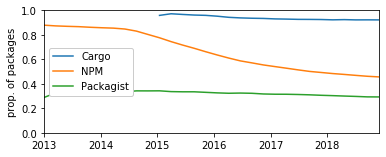

In [5]:
fig, ax = matplotlib.pyplot.subplots()

dates = pandas.date_range(*DATE_RANGE, periods=30)
data = dict()

for ecosystem in ECOSYSTEMS:
    data[ecosystem] = []
    
    _ = df_releases[ecosystem]
    for date in reversed(dates):
        _ = _[lambda d: d['date'] <= date]
        
        data[ecosystem].append((
            date, 
            _.package.nunique(),
            len(_.drop_duplicates('package', keep='last')[lambda d: d['major'] == 0]),
        ))
    
    (
        pandas.DataFrame(data[ecosystem], columns=['date', 'packages', 'zero'])
        .set_index('date')
        .sort_index()
        .assign(**{ecosystem: lambda d: d['zero'] / d['packages']})
        [[ecosystem]]
        .plot(ax=ax, color=COLORS[ecosystem])
    )
    
ax.set(
    xlabel='', 
    xlim=DATE_RANGE,
    ylabel='prop. of packages',
    ylim=(0, 1)
)
ax.legend(loc='center left')
fig.autofmt_xdate(bottom=0.2, rotation=0, ha='center')

savefig(fig, 'prevalence_packages')    

In [6]:
_ = pandas.concat([
    pandas.DataFrame(data[ecosystem], columns=['date', 'packages', 'zero'])
    .set_index('date')
    .eval('prop = zero / packages')
    .assign(ecosystem=ecosystem)
for ecosystem in ECOSYSTEMS], axis=0)

_.sort_index().iloc[-len(ECOSYSTEMS):]

,packages,zero,prop,ecosystem
date,,,,
2018-11-30,862698,393969,0.456671,NPM
2018-11-30,140971,41307,0.293018,Packagist
2018-11-30,20038,18483,0.922397,Cargo


### Monthly proportion of 0.y.z updates

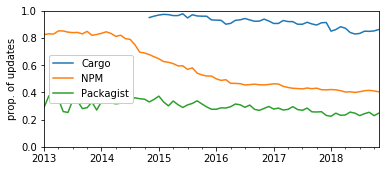

In [7]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_releases[ecosystem]
        .assign(dev=lambda d: d['major'] == 0)
        .groupby([pandas.Grouper(key='date', freq='M'), 'dev'])
        [['version']]
        .count()
        .unstack()['version']
        .assign(total=lambda d: d[True] + d[False])
        .assign(
            zero= lambda d: d[True] / d['total'],
            over= lambda d: d[False] / d['total'],
        )
    )
    
    data[ecosystem]['zero'].rename(ecosystem).plot(ax=ax, color=COLORS[ecosystem])

ax.legend()

ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='prop. of updates',
    ylim=(0, 1),
)

savefig(fig, 'prevalence_updates')

In [8]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .iloc[-1]
    .rename(ecosystem)
for ecosystem in ECOSYSTEMS], axis=1).loc[['zero', 'total']]

,Cargo,NPM,Packagist
dev,,,
zero,0.863387,0.404944,0.247996
total,4187,160084,13097


## How long does it take to reach 1.0.0?

a.k.a "The 1.0.0 barrier"

### Packages having reached the 1.0.0 barrier

In [9]:
df_temp = dict()

for ecosystem in ECOSYSTEMS:
    df_temp[ecosystem] = (
        df_releases[ecosystem]
        .sort_values('rank_date')
        .pipe(lambda df:
            (
                df
                [lambda d: d['major'] == 0]
                .drop_duplicates('package', keep='first')
                [['package', 'date']]
                .merge(
                    (
                        df
                        [lambda d: d['major'] > 0]
                        .drop_duplicates('package', keep='first')
                        [['package', 'date']]
                    ),
                    how='outer',
                    on='package',
                    suffixes=('_zero', '_nonzero'),
                )
            )
        )
    )

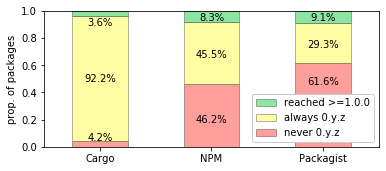

In [10]:
fix, ax = matplotlib.pyplot.subplots()

data = pandas.concat([
    df_temp[ecosystem]
    .assign(no_zero=lambda d: d['date_zero'].isnull())
    .assign(zero_no_one=lambda d: ~d['date_zero'].isnull() & d['date_nonzero'].isnull())
    .assign(zero_and_one=lambda d: ~d['date_zero'].isnull() & ~d['date_nonzero'].isnull())
    [['no_zero', 'zero_no_one', 'zero_and_one']]
    .sum()
    .rename(ecosystem)
    for ecosystem in ECOSYSTEMS], axis=1
)

_ = data.pipe(lambda s: s / s.sum()).T
_.plot.bar(stacked=True, color=PAL_REL, linewidth=1, edgecolor=(0, 0, 0, 0.3), ax=ax)

positions = [(0.07, 0.5, 0.91), (0.2, 0.68, 0.95), (0.48, 0.75, 0.95)]
for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, kind in enumerate(['no_zero', 'zero_no_one', 'zero_and_one']):
        ax.annotate('{:.1%}'.format(_.at[ecosystem, kind]), (i, positions[i][j]), ha='center', va='center')

ax.set(
    xlabel='',
    ylabel='prop. of packages',
    ylim=(0, 1), 
)

ax.legend(
    ax.get_legend_handles_labels()[0][::-1],
    ['never 0.y.z', 'always 0.y.z', 'reached >=1.0.0'][::-1], 
    loc='lower right'
)

ax.xaxis.set_tick_params(rotation=0)

savefig(fig, 'barrier_numbers')

### Time to reach 1.0.0

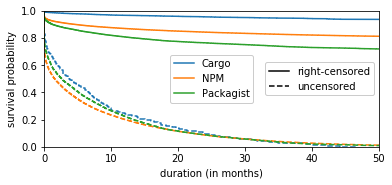

In [11]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    _ = (
        df_temp[ecosystem]
        .dropna(subset=['date_zero'])
        .assign(duration=lambda d: (d['date_nonzero'].fillna(CENSOR_DATE) - d['date_zero']).dt.days / 30)
        .assign(observed=lambda d: ~d['date_nonzero'].isnull())
    )

    
    kmf = lifelines.KaplanMeierFitter()
    kmf.fit(_.duration, _.observed, label=ecosystem)
    kmf.plot(ci_show=False, ax=ax, c=COLORS[ecosystem])
    
    
    kmf_ = lifelines.KaplanMeierFitter()
    kmf_.fit(_[_.observed].duration, label='')
    kmf_.plot(ci_show=False, ax=ax, c=COLORS[ecosystem], style='--')
    data[ecosystem] = (kmf, kmf_)
    
ax.set(
    xlim=(0, 50),
    xlabel='duration (in months)',
    ylim=(0, 1),
    ylabel='survival probability'
)

legend = ax.legend(loc='center')
ax.legend(
    [patch('k', '-'), patch('k', '--')],
    ['right-censored', 'uncensored'],
    loc='center right',
)
ax.add_artist(legend)

savefig(fig, 'barrier_time')

In [12]:
pandas.concat([
    pandas.concat([
        data[ecosystem][i]
        .survival_function_at_times([1, 3, 6, 12, 18, 24, 36, 48, 60])
        .rename(ecosystem)
        for ecosystem in ECOSYSTEMS
    ], axis=1).rename(columns=lambda x: x + '_' + label)
    for i, label in enumerate(['censored', 'uncensored'])
], axis=1).style.format("{:.2%}")

,Cargo_censored,NPM_censored,Packagist_censored,Cargo_uncensored,NPM_uncensored,Packagist_uncensored
1,98.78%,92.93%,90.63%,67.48%,54.16%,60.61%
3,98.20%,91.10%,87.63%,53.25%,42.76%,48.26%
6,97.74%,89.29%,84.85%,42.95%,32.05%,37.20%
12,96.78%,87.06%,80.89%,24.53%,20.17%,22.56%
18,96.18%,85.55%,78.07%,15.85%,13.22%,13.28%
24,95.61%,84.40%,76.51%,9.76%,8.73%,8.86%
36,94.68%,82.68%,73.78%,3.12%,3.66%,3.09%
48,93.76%,81.47%,72.21%,0.00%,1.39%,1.05%
60,93.76%,80.63%,70.96%,0.00%,0.52%,0.27%


### Update delay before and after 1.0.0

a.k.a "Major version zero is all about rapid development"

In [13]:
data = pandas.concat([
    df_releases[ecosystem]
    #[lambda d: d['package'].isin(has_both[ecosystem])]
    .assign(when=lambda d: pandas.np.where(d['major'] == 0, '0.y.z', '>=1.0.0'))
    .groupby(['package', 'when'], sort=False)
    .agg(
        first=('date', 'min'),
        last=('date', 'max'),
        nb=('version', 'count'),
    )
    .reset_index()
    .assign(delay=lambda d: (d['last'] - d['first']).dt.days / d['nb'])
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'when', 'nb', 'delay']]
    for ecosystem in ECOSYSTEMS],
    axis=0
)

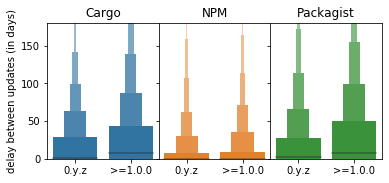

In [14]:
fig, axes = matplotlib.pyplot.subplots(
    ncols=len(ECOSYSTEMS), 
    sharex=False, 
    sharey=True,
    gridspec_kw=dict(wspace=0)
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    seaborn.boxenplot(
        y='delay',
        x='when',
        data=data[lambda d: d['ecosystem'] == ecosystem],
        order=['0.y.z', '>=1.0.0'],
        color=COLORS[ecosystem],
        ax=axes[i],
    )
    
    axes[i].set(
        title=ecosystem,
        xlabel='', 
        ylabel=''
    )

axes[0].set(
    xlabel='',
    ylabel='delay between updates (in days)',
    ylim=(0, 180),
)

savefig(fig, 'rapid_update_delay')

In [15]:
(
    data
    .groupby(['ecosystem', 'when'])
    [['nb', 'delay']]
    .describe()
    .T
)

ecosystem           Cargo                         NPM                 \
when                0.y.z      >=1.0.0          0.y.z        >=1.0.0   
nb    count  19762.000000  1611.000000  473044.000000  479705.000000   
      mean       5.155551     6.991930       6.161573       6.385971   
      std        8.344233    22.239226      14.446370      25.246839   
      min        1.000000     1.000000       1.000000       1.000000   
      25%        1.000000     1.000000       1.000000       1.000000   
      50%        2.000000     3.000000       3.000000       2.000000   
      75%        6.000000     6.000000       6.000000       6.000000   
      max      210.000000   321.000000    1984.000000    5301.000000   
delay count  19762.000000  1611.000000  473044.000000  479705.000000   
      mean      23.956707    34.459673      14.168324      15.093580   
      std       47.148410    61.351909      41.897187      41.389848   
      min        0.000000     0.000000       0.000000       0.000000   
      25%        0.000000     0.000000       0.000000       0.000000   
      50%        1.400000     8.000000       0.000000       0.000000   
      75%       29.500000    42.972826       8.272727       9.050000   
      max      609.000000   587.500000    1176.000000    1225.500000   

ecosystem       Packagist                 
when                0.y.z        >=1.0.0  
nb    count  54565.000000  100508.000000  
      mean       5.653642       7.764735  
      std        9.471647      19.998140  
      min        1.000000       1.000000  
      25%        1.000000       1.000000  
      50%        3.000000       3.000000  
      75%        6.000000       7.000000  
      max      371.000000    2316.000000  
delay count  54565.000000  100508.000000  
      mean      26.639435      39.453480  
      std       58.231632      71.907947  
      min        0.000000       0.000000  
      25%        0.000000       0.000000  
      50%        2.000000       8.166667  
      75%       27.000000      50.333333  
      max      972.000000    2713.333333

Statistical comparisons based on Mann-Whitney U and Cliff's Delta:

In [16]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['when'] == '0.y.z')].delay
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['when'] == '>=1.0.0')].delay
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} before vs. after: p={:.5f}; |d|={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      before vs. after: p=0.00000; |d|=-0.120 (negligible)
NPM        before vs. after: p=0.00000; |d|=0.022 (negligible)
Packagist  before vs. after: p=0.00000; |d|=-0.116 (negligible)


## How permissive are pre-1.0.0 dependency constraints?

a.k.a. "Major version zero (0.y.z) is for initial development. Anything MAY change at any time."

### Permissiveness of pre-1.0.0 constraints

Only versions released during a month are considered for this month.

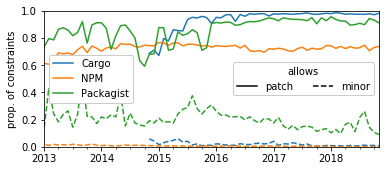

In [17]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_dependencies[ecosystem]
        [lambda d: d['i_dev'] == True]
        .merge(
            df_releases[ecosystem][['package', 'date', 'rank']],
            how='inner',
            left_on=['source', 'rank'],
            right_on=['package', 'rank'],
        )
        .groupby(pandas.Grouper(key='date', freq='M'))
        .agg({
            'constraint': 'count',
            'i_minor': 'sum',
            'i_patch': 'sum',
        })
        .eval('minor = i_minor / constraint')
        .eval('patch = i_patch / constraint')
    )
    
    data[ecosystem][['patch', 'minor']].plot(
        color=2 * [COLORS[ecosystem]], 
        style=['-', '--'],
        legend=False,
        ax=ax
    )

legend = ax.legend(
    [patch(COLORS[ecosystem], '-') for ecosystem in ECOSYSTEMS],
    ECOSYSTEMS,
    loc='center left',
)

ax.legend(
    [patch('k', '-'), patch('k', '--')],
    ['patch', 'minor'],
    loc='center right',
    title='allows',
    ncol=2,
)

ax.add_artist(legend)

ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='prop. of constraints',
    ylim=(0, 1),
)

savefig(fig, 'stable_permissiviness')

In [18]:
_ = pandas.concat([
        data[ecosystem]
        .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS
    ], 
    axis=0
)

_.groupby('ecosystem')[['minor', 'patch']].describe().T

ecosystem        Cargo        NPM  Packagist
minor count  50.000000  97.000000  84.000000
      mean    0.019319   0.013896   0.187403
      std     0.013857   0.016603   0.107717
      min     0.003348   0.000000   0.000000
      25%     0.009698   0.004208   0.132726
      50%     0.014533   0.006679   0.181665
      75%     0.023139   0.015329   0.232919
      max     0.060491   0.069534   0.692308
patch count  50.000000  97.000000  84.000000
      mean    0.938449   0.659588   0.845698
      std     0.078535   0.149831   0.144759
      min     0.672106   0.000000   0.000000
      25%     0.949677   0.613568   0.814271
      50%     0.974620   0.721693   0.895612
      75%     0.978397   0.740266   0.924854
      max     0.987158   0.767884   1.000000

In [19]:
_.sort_index().iloc[-len(ECOSYSTEMS):]

,constraint,i_minor,i_patch,minor,patch,ecosystem
date,,,,,,
2018-12-31,93600,419.0,68503.0,0.004476,0.731870,NPM
2018-12-31,11003,40.0,10649.0,0.003635,0.967827,Cargo
2018-12-31,1489,150.0,1319.0,0.100739,0.885829,Packagist


### Focusing on the latest snapshot

In [20]:
data = pandas.concat([
    df_dependencies[ecosystem]
    .sort_values('rank')
    .drop_duplicates(['source', 'target'], keep='last')
    .assign(
        n=1,
        # Correct values, as patch superseeded by minor superseeded by major
        patch=lambda d: d['i_patch'] & ~d['i_minor'] & ~d['i_major'],
        minor=lambda d: d['i_minor'] & ~d['i_major'],
        major=lambda d: d['i_major'],
    )
    .pivot_table(index='i_dev', values=['n', 'major', 'minor', 'patch'], aggfunc='sum')
    .apply(lambda s: s / s.n, axis=1)
    .drop(columns=['n'])
    .reset_index()
    .rename(columns={'i_dev': 'kind'})
    .replace({'kind': {True: '0.y.z', False: '>=1.0.0'}})
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS],
    axis=0
).set_index(['ecosystem', 'kind'])

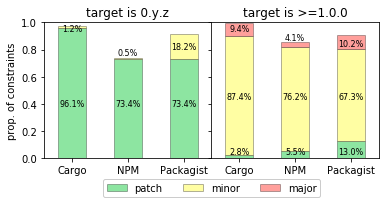

In [21]:
fig, axes = matplotlib.pyplot.subplots(
    ncols=2, 
    sharex=False, 
    sharey=True,
    gridspec_kw=dict(wspace=0)
)

for i, kind in enumerate(['0.y.z', '>=1.0.0']):
    (
        data
        .xs(kind, level=1)
        [['patch', 'minor', 'major']]
        .plot.bar(stacked=True, color=PAL_REL[::-1], linewidth=1, edgecolor=(0, 0, 0, 0.3), legend=False, ax=axes[i])
    )
    
    axes[i].set(
        title='target is {}'.format(kind),
        xlabel='', 
        ylabel=''
    )
    axes[i].xaxis.set_tick_params(rotation=0)

positions = [
    ((0.40, 0.95), (0.05, 0.45, 0.95)),
    ((0.40, 0.78), (0.05, 0.45, 0.89)),
    ((0.40, 0.82), (0.05, 0.45, 0.84)),
]
for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, kind in enumerate(['0.y.z', '>=1.0.0']):
        for k, release in enumerate(['patch', 'minor', 'major']):
            value = data.loc[ecosystem, kind][release]
            if kind == '0.y.z' and release == 'major':
                continue
            axes[j].annotate('{:.1%}'.format(value), (i, positions[i][j][k]), size=8, ha='center', va='center')
    
axes[0].legend(
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(1, -0.32),
)

axes[0].set(
    xlabel='',
    ylabel='prop. of constraints',
    ylim=(0, 1),
)

savefig(fig, 'stable_snapshot')

In [22]:
data.T

ecosystem     Cargo                 NPM           Packagist          
kind        >=1.0.0     0.y.z   >=1.0.0     0.y.z   >=1.0.0     0.y.z
major      0.093905  0.000000  0.040975  0.000000  0.102170  0.000000
minor      0.874108  0.011926  0.761615  0.005434  0.672813  0.182107
patch      0.027988  0.960552  0.055290  0.734251  0.130111  0.733719

## To what extent are 0.y.z packages used by other packages?

a.k.a. "If your software is being used in production, it should probably already be 1.0.0. If you have a stable API on which users have come to depend, you should be 1.0.0."

### Number of dependents for required packages above and below 1.0.0

Only the last snapshot of each ecosystem is considered. 

Only packages with at least one reverse dependency are considered.

In [23]:
data = pandas.concat([
    df_dependencies[ecosystem]
    .sort_values('rank')
    .drop_duplicates('source', keep='last')
    .groupby(['target', 'i_dev'], sort=False, as_index=False)
    [['source']]
    .count()
    .assign(ecosystem=ecosystem)
    .replace({'i_dev': {True: '0.y.z', False: '>=1.0.0'}})
    for ecosystem in ECOSYSTEMS
], axis=0)

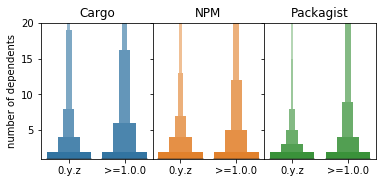

In [24]:
fig, axes = matplotlib.pyplot.subplots(
    ncols=len(ECOSYSTEMS), 
    sharex=False, 
    sharey=True,
    gridspec_kw=dict(wspace=0)
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    seaborn.boxenplot(
        y='source',
        x='i_dev',
        data=data[lambda d: d['ecosystem'] == ecosystem],
        order=['0.y.z', '>=1.0.0'],
        color=COLORS[ecosystem],
        ax=axes[i],
    )
    
    axes[i].set(
        title=ecosystem,
        xlabel='', 
        ylabel=''
    )

axes[0].set(
    xlabel='',
    ylabel='number of dependents',
    ylim=(1, 20),
)

savefig(fig, 'usage_dependents')

In [25]:
(
    data
    .groupby(['ecosystem', 'i_dev'])
    [['source']]
    .describe()
    .T
)

ecosystem           Cargo                       NPM                \
i_dev               0.y.z     >=1.0.0         0.y.z       >=1.0.0   
source count  2395.000000  478.000000  31188.000000  47385.000000   
       mean      4.578706    8.548117      3.995415      9.154838   
       std      26.522700   40.139129     40.258364    141.980004   
       min       1.000000    1.000000      1.000000      1.000000   
       25%       1.000000    1.000000      1.000000      1.000000   
       50%       1.000000    1.000000      1.000000      1.000000   
       75%       2.000000    2.000000      2.000000      2.000000   
       max     959.000000  459.000000   3553.000000  17122.000000   

ecosystem       Packagist                
i_dev               0.y.z       >=1.0.0  
source count  3483.000000  13686.000000  
       mean      2.108240      6.769619  
       std       4.435516     85.630391  
       min       1.000000      1.000000  
       25%       1.000000      1.000000  
       50%       1.000000      1.000000  
       75%       2.000000      2.000000  
       max      91.000000   5514.000000

In [26]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['i_dev'] == '0.y.z')].source
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['i_dev'] == '>=1.0.0')].source
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} before vs. after: p={:.5f}; |d|={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      before vs. after: p=0.00561; |d|=-0.062 (negligible)
NPM        before vs. after: p=0.00000; |d|=-0.063 (negligible)
Packagist  before vs. after: p=0.00000; |d|=-0.097 (negligible)


### Dependencies between 0.y.z and >=1.0.0 packages

Only the latest snapshot is considered. 

In [27]:
data = pandas.concat([
    df_dependencies[ecosystem]
    [['source', 'target', 'rank', 'i_dev']]
    .merge(
        df_releases[ecosystem].sort_values('rank').drop_duplicates('package', keep='last')[['package', 'major', 'rank']],
        how='inner',
        left_on=['source', 'rank'],
        right_on=['package', 'rank'],
    )
    .drop(columns=['package'])
    .assign(source_kind=lambda d: pandas.np.where(d['major'] < 1.0, '0.y.z', '>=1.0.0'))
    .assign(target_kind=lambda d: pandas.np.where(d['i_dev'], '0.y.z', '>=1.0.0'))
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'source', 'target', 'source_kind', 'target_kind']]
    for ecosystem in ECOSYSTEMS],
    axis=0
)

In [28]:
pandas.concat([
    data[data['ecosystem'] == ecosystem].pipe(lambda df:
        pandas.crosstab([df.ecosystem, df.source_kind], df.target_kind, normalize='all')
    )
    for ecosystem in ECOSYSTEMS
], axis=0)

target_kind               0.y.z   >=1.0.0
ecosystem source_kind                    
Cargo     0.y.z        0.677346  0.242499
          >=1.0.0      0.050597  0.029558
NPM       0.y.z        0.127652  0.343802
          >=1.0.0      0.087050  0.441497
Packagist 0.y.z        0.047687  0.247109
          >=1.0.0      0.025827  0.679378

### Grouped by (source, target) packages.

In [32]:
data = pandas.concat([
    df_dependencies[ecosystem]
    [['source', 'target', 'rank', 'i_dev']]
    .merge(
        (
            df_releases[ecosystem]
            .drop_duplicates('package', keep='last')
            .assign(source_pre=lambda d: d['major'] < 1.0)
            [['package', 'rank', 'source_pre']]
        ),
        how='inner',
        left_on=['source', 'rank'],
        right_on=['package', 'rank'],
    )
    #.drop(columns=['package'])
    #.merge(
    #    (
    #        df_releases[ecosystem]
    #        .drop_duplicates('package', keep='last')
    #        .assign(target_pre=lambda d: d['major'] < 1.0)
    #        [['package', 'target_pre']]
    #    ),
    #    how='inner',
    #    left_on=['target'],
    #    right_on=['package'],
    #)
    .assign(target_pre=lambda d: d['i_dev'])
    .drop(columns=['package', 'rank', 'i_dev'])
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS],
    axis=0
)

In [33]:
ndata = []

for ecosystem in ECOSYSTEMS:
    dependents = (
        data
        [lambda d: d['ecosystem'] == ecosystem]
        .groupby(['source'], sort=False, as_index=False)
        .agg({'source_pre': 'first', 'target_pre': 'max'})
    )
    required = (
        data
        [lambda d: d['ecosystem'] == ecosystem]
        .groupby(['target'], sort=False, as_index=False)
        .agg({'source_pre': 'min', 'target_pre': 'first'})
    )
    
    for source in [True, False]:
        for target in [True, False]:
            sources = len(dependents[lambda d: (d['source_pre'] == source) & (d['target_pre'] == target)])
            targets = len(required[lambda d: (d['source_pre'] == source) & (d['target_pre'] == target)])
            ndata.append((
                ecosystem,
                '0.y.z' if source else '>=1.0.0',
                '0.y.z' if target else '>=1.0.0',
                sources,
                sources / len(dependents),
                targets,
                targets / len(required),
            ))
        
ndata = pandas.DataFrame(columns=['ecosystem', 'source', 'target', 'sources', 'p_sources', 'targets', 'p_targets'], data=ndata)

In [34]:
(
    ndata
    .pivot_table(index=['ecosystem', 'source'], columns=['target'], values=['p_sources', 'p_targets'], aggfunc='first')
    .style.format('{:.1%}').background_gradient(axis=None)
)